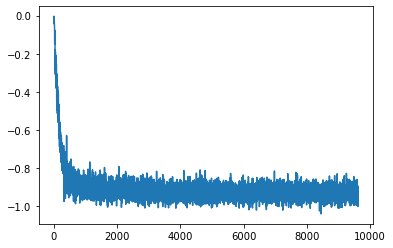

In [2]:
import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

import numpy as np
import matplotlib.pyplot as plt

import os, sys
currentdir = os.path.dirname(os.getcwd())
sys.path.append(currentdir)

loss = np.load('../saved/losses_06.npy')

plt.figure()
plt.plot(loss)
plt.show()

In [3]:
import torch
from model import ARSegmentationNet
from dataloader import Potsdam, PotsdamDataLoader

# get the dataloader
path = '/mnt/D2/Data/potsdam/preprocessed/'
validation_dataset = Potsdam(path, split='labelled_test', is_test=True)
validation_loader = PotsdamDataLoader(validation_dataset, batch_size=10)

# get a batch of images and labels from the dataloader
dataiter = iter(validation_loader)


In [16]:
images, labels = dataiter.next()
labels = labels.detach().numpy()

# load the model architecture and trained weights
state_dict = torch.load('../saved/model_02.pth')
model = ARSegmentationNet()
model.load_state_dict(state_dict)

# run the model on the images
out = model(images, 0).detach().numpy()
print(out.shape)
out_preds = np.argmax(out, axis=1)

labels[labels == 4] = 0 # merge road and cars classes...? this seems questionable but that's how they do
labels[labels == 5] = 1 # merge buildings and clutter classes
labels[labels == 3] = 2 # merge vegetation and trees classes

(10, 3, 200, 200)


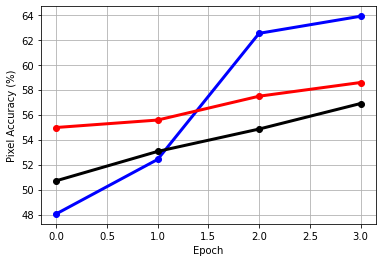

In [15]:
from scipy.optimize import linear_sum_assignment as linear_assignment
import pickle
f = open('../saved/model_002_dist.pkl', 'rb')
dists = pickle.load(f)
f.close()

f = open('../saved/model_004_dist.pkl', 'rb')
dists2 = pickle.load(f)
f.close()

f = open('../saved/model_006_dist.pkl', 'rb')
dists3 = pickle.load(f)
f.close()


acc = np.zeros((10,))
for i,d in enumerate(dists):
    ri, ci = linear_assignment(d, maximize=True)
    corr = d[ri, ci].sum()
    acc[i] = corr/d.sum()
    
acc2 = np.zeros((10,))
for i,d in enumerate(dists2):
    ri, ci = linear_assignment(d, maximize=True)
    corr = d[ri, ci].sum()
    acc2[i] = corr/d.sum()
    
acc3 = np.zeros((10,))
for i,d in enumerate(dists3):
    ri, ci = linear_assignment(d, maximize=True)
    corr = d[ri, ci].sum()
    acc3[i] = corr/d.sum()
    
plt.figure()
plt.plot(acc[:4]*100, 'bo-', linewidth=3)
plt.plot(acc2[:4]*100, 'ro-', linewidth=3)
plt.plot(acc3[:4]*100, 'ko-', linewidth=3)
plt.grid()
plt.ylabel("Pixel Accuracy (%)")
plt.xlabel("Epoch")
plt.show()
    

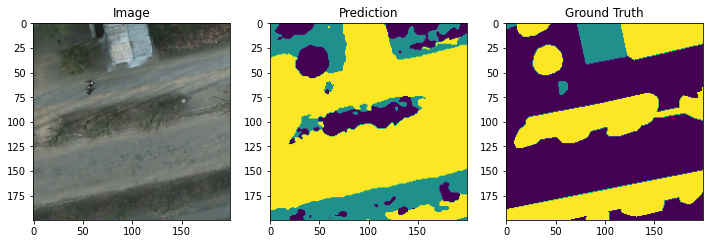

In [6]:
img = 6

out_labels = out_preds.copy()
# out_labels[out_preds == ci[0] ] = 0
# out_labels[out_preds == ci[1] ] = 1
# out_labels[out_preds == ci[2] ] = 2

out_labels[out_preds == 0 ] = ci[0]
out_labels[out_preds == 1 ] = ci[1]
out_labels[out_preds == 2 ] = ci[2]


plt.figure(figsize=(12,8))
plt.subplot(131)
plt.imshow(images[img,:3,:,:].permute(1,2,0)/255)
plt.title("Image")
plt.subplot(132)
plt.imshow(out_labels[img,:,:])
plt.title("Prediction")
plt.subplot(133)
plt.imshow(labels[img,:,:])
plt.title("Ground Truth")
plt.show()
# plt.savefig("out3.png", dpi=300)

In [17]:
a = model.resblock1.conv1.mask

b = a[0,0,:,:]

b

tensor([[ 0.0191,  0.0311, -0.0413],
        [-0.0225,  0.0295, -0.0265],
        [ 0.0025,  0.0000,  0.0000]])

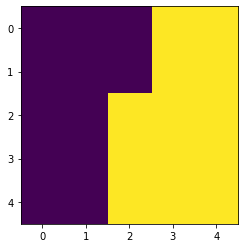

In [14]:
def create_masks(H):
    '''creates the attention mask for each ordering'''
    
    # allocate space
    mask = np.zeros((8, H, H))
    
    # create attention masks for each ordering
    for ordering in range(1,9):
        
        a = np.ones((H,H))
        a[H//2, H//2+1:]=0
        a[H//2+1:,:] = 0
        
        if ordering == 2:
            a = np.flip(np.rot90(a, 1), 0)  # CCW 90, flip V
        elif ordering==3:
            a = np.flip(a, 1)               # flip H
        elif ordering==4:
            a = np.rot90(a, 3)              # CCW 270
        elif ordering==5:
            a = np.rot90(a, 1)              # CCW 90
        elif ordering==6:
            a = np.flip(a, 0)               # flip V
        elif ordering==7:
            a = np.rot90(a, 2)              # CCW 180
        elif ordering==8:
            a = np.flip(np.rot90(a, 3), 0)  # CCW 270, flip V
            
        mask[ordering-1,:,:] = a
    
    return mask

msk = create_masks(5)

plt.figure()
plt.imshow(msk[7,:,:])
plt.show()